# RNN: Hyperparameter Optimization

In [111]:
import os
import numpy as np
import pandas as pd

# for printing the definition of custom functions
import inspect

# models
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

from pmdarima.arima import auto_arima

# pytorch
from torch import nn, no_grad, save, load
from torch import from_numpy, zeros
from torch.optim import SGD
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

# plots
import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')
%matplotlib inline

import pickle

In [113]:
models = []
n_epochs = 1000

In [114]:
database_dir = os.path.join(r'C:/Users/hauer/Documents/Repositories/cfds_project', 'database.pickle')

with open(database_dir,'rb') as f: 
    db = pickle.load(f)
    
database_training = db['database_training']
database_validation = db['database_validation']
database_test = db['database_test']

database_training_sv = db['database_training_sv']
database_validation_sv = db['database_validation_sv']
database_test_sv = db['database_test_sv']

database_training_sv_standard = db['database_training_sv_standard']
database_validation_sv_standard = db['database_validation_sv_standard']
database_test_sv_standard = db['database_test_sv_standard']

database_scaler = db['database_scaler']

In [116]:
# =============================================================================
# RNN start
# =============================================================================


# =============================================================================
# # Prepare Data for RNN
# =============================================================================



N, dummy_dim = database_training_sv_standard['Germany'].shape
dummy_dim -= 1

time_steps = 16
horizon = 1
sequence_length = time_steps + horizon 


max_index = N - sequence_length + 1

number_of_countries = len(database_training_sv_standard.keys())

X = np.empty([0, sequence_length,dummy_dim])
y = np.empty([0, sequence_length])

 

for country in database_training.keys():
    df_training_current = database_training_sv_standard[country]

    X_current = np.empty([max_index, sequence_length,dummy_dim])
    y_current = np.empty([max_index, sequence_length])

    for i in range(max_index):

        X_current[i] = df_training_current.iloc[i:i+sequence_length,1:].values
        y_current[i] = df_training_current.iloc[i:i+sequence_length,0].values
        
    X = np.concatenate((X, X_current))
    y = np.concatenate((y, y_current))
    
    
    

N, seq_len, dummy_dim = X.shape

input_size=dummy_dim
n_layers=1
output_size=1
test_size = 0.02
batch_size = 25




X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=123)


X_train_T = from_numpy(X_train).float()
y_train_T = from_numpy(y_train).float()
X_val_T = from_numpy(X_val).float()
y_val_T = from_numpy(y_val).float()

train_ds = TensorDataset(X_train_T, y_train_T)
train_dl = DataLoader(train_ds, batch_size=batch_size)  

valid_ds = TensorDataset(X_val_T, y_val_T)
valid_dl = DataLoader(valid_ds, batch_size=batch_size * 2)

loss_func = nn.MSELoss()

# Simple RNN

In [13]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN'
hidden_dim=3
lr = 0.03

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))

Epoch 0: train loss: 23.08 valid loss: 1.136


# Simple RNN Adam

In [6]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN_Adam'
hidden_dim=3
lr = 1e-06

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)
 

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))


Epoch 0: train loss: 25.01 valid loss: 1.384


# RNN Large

In [7]:
class RNN(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(RNN, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden):
        r_out, hidden = self.rnn(x, hidden)
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)
    
name = 'RNN_Large_Adam'
hidden_dim=64
lr = 1e-06

model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)
 

hidden_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)

# =============================================================================
# # Training loop 
# =============================================================================

for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))   
        
models.append( (name, training_losses, valid_losses))


Epoch 0: train loss: 21.51 valid loss: 1.07


# Simple LSTM

In [88]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, state):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden, state))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM'
hidden_dim=10
lr = 0.03

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_0 = zeros(1, seq_len, hidden_dim)
state_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0, state_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0, state_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 22.29 valid loss: 1.108
Epoch 100: train loss: 20.49 valid loss: 1.017
Epoch 200: train loss: 19.78 valid loss: 0.9312


# Stacked Simple LSTM

In [117]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden_1, state_1, hidden_2, state_2):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden_1, state_1))      
        r_out, (hidden_out, state_out) = self.lstm2(r_out, (hidden_2, state_2))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM_Stacked'
hidden_dim=10
lr = 0.03

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = SGD(model.parameters(), lr = lr)  

hidden_01 = zeros(1, seq_len, hidden_dim)
state_01 = zeros(1, seq_len, hidden_dim)

hidden_02 = zeros(1, seq_len, hidden_dim)
state_02 = zeros(1, seq_len, hidden_dim)

training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_01, state_01, hidden_02, state_02)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_01, state_01, hidden_02, state_02)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 22.51 valid loss: 1.326
Epoch 100: train loss: 22.12 valid loss: 1.311
Epoch 200: train loss: 21.79 valid loss: 1.292
Epoch 300: train loss: 21.19 valid loss: 1.242
Epoch 400: train loss: 19.97 valid loss: 1.156
Epoch 500: train loss: 18.18 valid loss: 1.059
Epoch 600: train loss: 16.59 valid loss: 1.025
Epoch 700: train loss: 15.0 valid loss: 1.012
Epoch 800: train loss: 13.35 valid loss: 0.9867
Epoch 900: train loss: 11.74 valid loss: 0.9423


# LSTM Adam Large

In [10]:
class LSTMNet(nn.Module):
    def __init__(self, input_size, seq_len, output_size, hidden_dim, n_layers):
        super(LSTMNet, self).__init__()

        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
               
        
        self.lstm1 = nn.LSTM(input_size, hidden_dim)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, hidden, state):
        r_out, (hidden_out, state_out) = self.lstm1(x, (hidden, state))
        r_out = self.fc(r_out)
        
        return r_out
        
    def initHidden(self):
        return zeros(1, self.seq_len, self.hidden_dim)




name = 'LSTM_Large_Adam'
hidden_dim=64
lr = 1e-06

model = LSTMNet(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
optimizer = Adam(model.parameters(), lr=lr)


hidden_0 = zeros(1, seq_len, hidden_dim)
state_0 = zeros(1, seq_len, hidden_dim)
training_losses = np.empty(n_epochs)
valid_losses = np.empty(n_epochs)


    
# =============================================================================
# # Training loop 
# =============================================================================



for epoch in range(n_epochs):
    model.train()
    training_loss = 0
    for X_batch, y_batch in train_dl:
        optimizer.zero_grad()
        
        y_pred = model(X_batch, hidden_0, state_0)
        
        loss = loss_func(y_pred.squeeze(), y_batch)
        
        training_loss += loss.item()
       

        loss.backward()
        optimizer.step()
   

    model.eval()
    valid_loss = 0
    with no_grad():
        for X_batch, y_batch in valid_dl:
            y_pred = model(X_batch, hidden_0, state_0)
            loss = loss_func(y_pred.squeeze(), y_batch.squeeze()) 
            valid_loss += loss.item()
    
    
    training_loss_epoch = training_loss 
    valid_loss_epoch = valid_loss 
    
    training_losses[epoch] = training_loss_epoch
    valid_losses[epoch] = valid_loss_epoch
    
    if epoch % 100 == 0:
        print('Epoch {}: train loss: {:.4} valid loss: {:.4}'
              .format(epoch, training_loss_epoch, valid_loss_epoch))  
        
        
models.append( (name, training_losses, valid_losses))
    

Epoch 0: train loss: 21.42 valid loss: 1.102


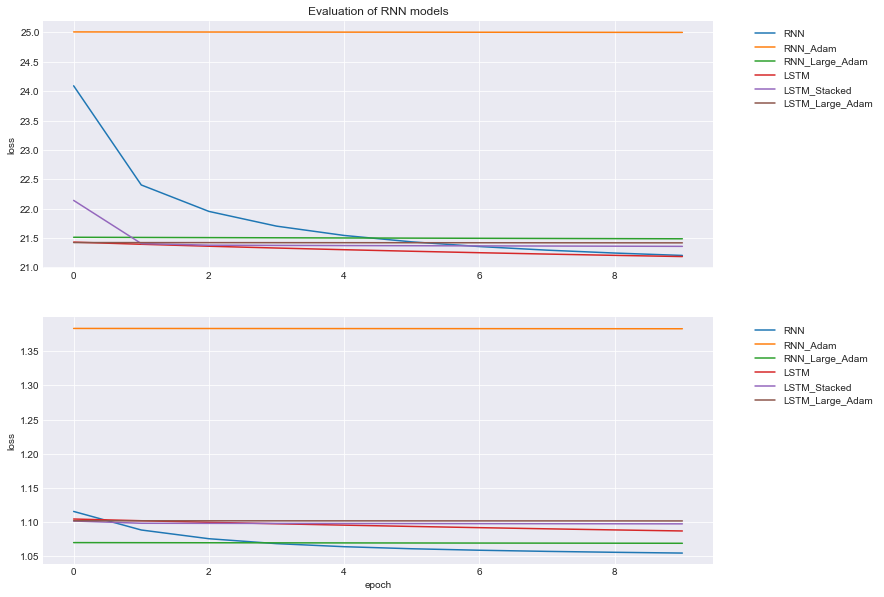

In [11]:
x = [i for i in range(n_epochs)]


fig, ax = plt.subplots(2,1, figsize=(12,10))

for model_ in models:
    name = model_[0]
    training_loss = model_[1]
    valid_loss =model_[2] 

    
    label = name 
    
    ax[0].plot(x,  training_loss, label=label)
    ax[1].plot(x,  valid_loss, label=label)


ax[1].set_xlabel('epoch') 
ax[0].set_ylabel('loss') 
ax[1].set_ylabel('loss')
ax[0].set_title("Evaluation of RNN models")
legend  = ax[0].legend(bbox_to_anchor=(1.05, 1))
legend  = ax[1].legend(bbox_to_anchor=(1.05, 1))

ax[0].grid()
ax[1].grid()

# Serializing best model

In [118]:

# =============================================================================
# # Serializing model 
# =============================================================================

wdir= r'C:/Users/hauer/Documents/Repositories/cfds_project'
save_dir = os.path.join(wdir, 'pytorch_models')
model_name = 'rnn.torch'

if(not os.path.isdir(save_dir)):
    os.mkdir(save_dir)
    
save(model.state_dict(), os.path.join(save_dir, model_name))

#model = RNN(input_size, seq_len, output_size=output_size, hidden_dim=hidden_dim, n_layers=n_layers)
#model.load_state_dict(load( os.path.join(save_dir, model_name)))

# Using model

In [120]:
country = 'Germany'

df = database_training[country].append(database_validation[country])

n_forecast_validation, _ = database_validation[country].shape

X_eval = df.iloc[:,1:].values
y_eval = df.iloc[:,0].values
X_eval_T = from_numpy(X_eval).float()
N, _ = X_eval_T.shape
X_eval_T = X_eval_T.view([-1, N, dummy_dim])

hidden_1 = zeros(1, N, hidden_dim)
state_1 = zeros(1, N, hidden_dim)

hidden_2 = zeros(1, N, hidden_dim)
state_2 = zeros(1, N, hidden_dim)

model.eval()
with no_grad():
    y_hat = model(X_eval_T, hidden_1, state_1, hidden_2, state_2)
    
y_hat =  y_hat.view(-1).numpy()
y_forecast = y_hat[-n_forecast_validation:]
y_forecast

array([-0.4447406 , -0.5383673 , -0.54223335,  1.1569089 ], dtype=float32)

Transforming the output back to original scale: 

In [121]:
df_temp = database_validation_sv_standard[country]
df_temp

,0,1,2,3,4,5,6
0,0.112078,0.167094,2.859324,-0.585986,0.441525,-0.430321,0.196357
1,0.020610,-0.202866,-3.353978,-0.566551,0.167973,-0.004093,0.204739
2,0.194134,0.703271,1.380498,0.312143,0.175346,2.585039,0.185738
3,0.554966,-0.584436,-1.481537,-0.817997,0.198065,-705.418324,0.174476


In [122]:
df_temp = pd.DataFrame(scaler.inverse_transform(df_temp))
df_temp

,0,1,2,3,4,5,6
0,2.108334,0.685485,0.701360,0.561683,3.323391,4.584219,1.156301
1,1.952093,0.682864,0.628440,0.562902,2.826890,4.591167,1.169023
2,2.248498,0.689282,0.684005,0.618015,2.840272,4.633373,1.140183
3,2.864855,0.680162,0.650415,0.547131,2.881507,-6.907755,1.123090


In [123]:
df_temp.iloc[:,0] = y_forecast
df_temp

,0,1,2,3,4,5,6
0,-0.444741,0.685485,0.701360,0.561683,3.323391,4.584219,1.156301
1,-0.538367,0.682864,0.628440,0.562902,2.826890,4.591167,1.169023
2,-0.542233,0.689282,0.684005,0.618015,2.840272,4.633373,1.140183
3,1.156909,0.680162,0.650415,0.547131,2.881507,-6.907755,1.123090


In [124]:
pd.DataFrame(scaler.inverse_transform(df_temp))

,0,1,2,3,4,5,6
0,1.157204,0.689156,0.676034,0.633666,8.554008,4.665961,2.613293
1,0.997275,0.689138,0.675178,0.633743,7.652853,4.666074,2.632603
2,0.990671,0.689183,0.675830,0.637199,7.677142,4.666762,2.588831
3,3.893064,0.689119,0.675436,0.632753,7.751984,4.478631,2.562887


Comparing with the ground truth: 

In [125]:
 pd.DataFrame(scaler.inverse_transform(database_validation_sv_standard[country]))

,0,1,2,3,4,5,6
0,2.108334,0.685485,0.701360,0.561683,3.323391,4.584219,1.156301
1,1.952093,0.682864,0.628440,0.562902,2.826890,4.591167,1.169023
2,2.248498,0.689282,0.684005,0.618015,2.840272,4.633373,1.140183
3,2.864855,0.680162,0.650415,0.547131,2.881507,-6.907755,1.123090
